# Power Outage Prediction - Visualizations
## Exploratory Data Analysis Through Visualization

**Objective**: Create visualizations to understand patterns in weather-outage relationships for predictive modeling.

**Key Areas**:
- Weather variable distributions
- Temporal outage patterns  
- Geographic risk analysis
- Weather-outage correlations
- Extreme event analysis

In [1]:
# Setup and data loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Load integrated dataset
def load_integrated_data():
    data_dir = Path("../../data/processed")
    integrated_file = data_dir / "integrated_dataset.csv"
    
    if integrated_file.exists():
        df = pd.read_csv(integrated_file)
        df['date'] = pd.to_datetime(df['date'])
        return df
    else:
        raise FileNotFoundError("Run data integration notebook first")

# Create output directory
output_dir = Path("../../notebooks/outputs/milestone_1/visualizations")
output_dir.mkdir(parents=True, exist_ok=True)

df = load_integrated_data()
print(f"Dataset loaded: {df.shape}")
print(f"Outage rate: {df['outage_occurred'].mean():.1%}")

Dataset loaded: (366460, 17)
Outage rate: 9.4%


## Weather Variable Distributions

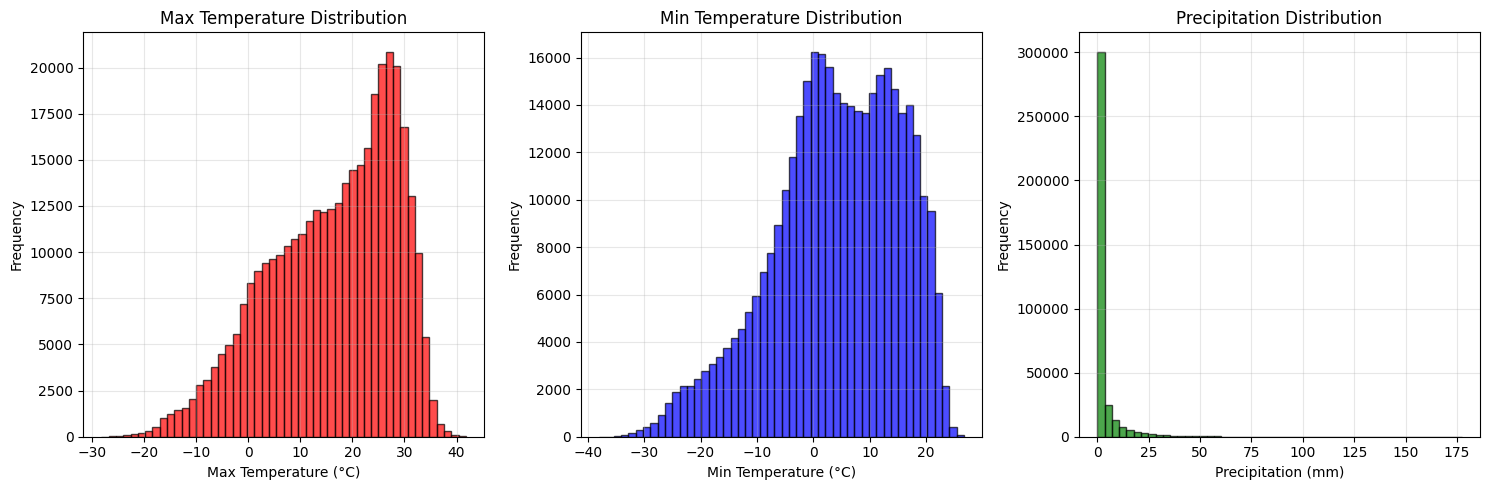

In [2]:
# Weather variable histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Temperature max
axes[0].hist(df['tmax'], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0].set_xlabel('Max Temperature (°C)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Max Temperature Distribution')
axes[0].grid(True, alpha=0.3)

# Temperature min
axes[1].hist(df['tmin'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1].set_xlabel('Min Temperature (°C)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Min Temperature Distribution')
axes[1].grid(True, alpha=0.3)

# Precipitation
axes[2].hist(df['prcp'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[2].set_xlabel('Precipitation (mm)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Precipitation Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'weather_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

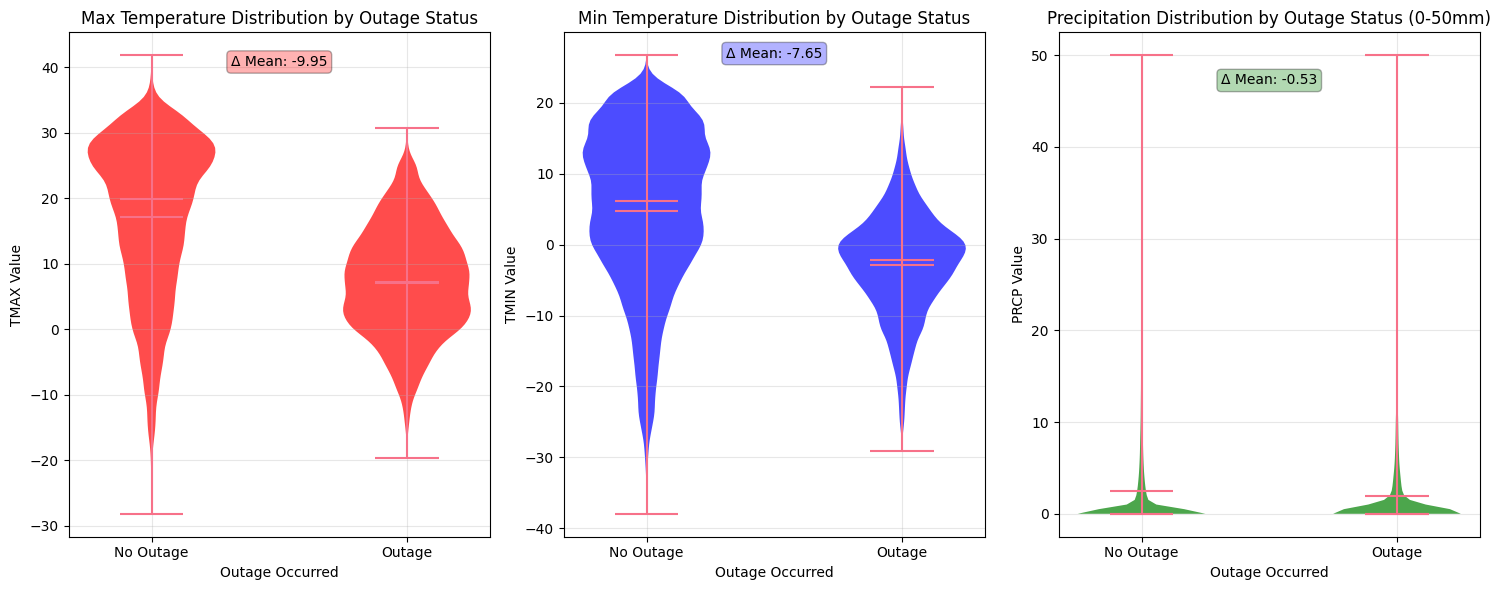

Weather Differences Between Outage vs No-Outage Days:

TMAX:
  No outage days: mean=17.15, std=12.00
  Outage days:    mean=7.20, std=8.20
  Difference:     -9.95

TMIN:
  No outage days: mean=4.75, std=11.40
  Outage days:    mean=-2.90, std=7.29
  Difference:     -7.65

PRCP (Full Range):
  No outage days: mean=2.76, std=7.42
  Outage days:    mean=2.19, std=6.63
  Difference:     -0.56

PRCP (0-50mm Range - 364,962 observations):
  No outage days: mean=2.50, std=6.15
  Outage days:    mean=1.97, std=5.44
  Difference:     -0.53


In [3]:
# Weather distributions by outage status (violin plots)
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

weather_vars = ['tmax', 'tmin', 'prcp']
colors = ['red', 'blue', 'green']
titles = ['Max Temperature Distribution by Outage Status', 'Min Temperature Distribution by Outage Status', 'Precipitation Distribution by Outage Status (0-50mm)']

for i, (var, color, title) in enumerate(zip(weather_vars, colors, titles)):
    # For precipitation, filter to 0-50mm range for better visualization
    if var == 'prcp':
        data_filtered = df[df[var] <= 50]
        no_outage = data_filtered[data_filtered['outage_occurred'] == 0][var]
        outage = data_filtered[data_filtered['outage_occurred'] == 1][var]
    else:
        no_outage = df[df['outage_occurred'] == 0][var]
        outage = df[df['outage_occurred'] == 1][var]
    
    # Create violin plot
    parts = axes[i].violinplot([no_outage, outage], positions=[0, 1], showmeans=True, showmedians=True)
    
    # Customize colors
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    axes[i].set_xlabel('Outage Occurred')
    axes[i].set_ylabel(f'{var.upper()} Value')
    axes[i].set_title(title)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['No Outage', 'Outage'])
    axes[i].grid(True, alpha=0.3)
    
    # Add summary statistics
    no_outage_mean = no_outage.mean()
    outage_mean = outage.mean()
    mean_diff = outage_mean - no_outage_mean
    
    axes[i].text(0.5, axes[i].get_ylim()[1] * 0.9, 
                f'Δ Mean: {mean_diff:.2f}', 
                ha='center', va='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.3))

plt.tight_layout()
plt.savefig(output_dir / 'weather_distributions_by_outage.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistical differences
print("Weather Differences Between Outage vs No-Outage Days:")
print("=" * 55)
for var in weather_vars:
    if var == 'prcp':
        # For precipitation, show both full range and 0-50mm range
        no_outage_data = df[df['outage_occurred'] == 0][var]
        outage_data = df[df['outage_occurred'] == 1][var]
        
        # 0-50mm range
        no_outage_filtered = df[(df['outage_occurred'] == 0) & (df[var] <= 50)][var]
        outage_filtered = df[(df['outage_occurred'] == 1) & (df[var] <= 50)][var]
        
        print(f"\n{var.upper()} (Full Range):")
        print(f"  No outage days: mean={no_outage_data.mean():.2f}, std={no_outage_data.std():.2f}")
        print(f"  Outage days:    mean={outage_data.mean():.2f}, std={outage_data.std():.2f}")
        print(f"  Difference:     {outage_data.mean() - no_outage_data.mean():.2f}")
        
        print(f"\n{var.upper()} (0-50mm Range - {len(no_outage_filtered)+len(outage_filtered):,} observations):")
        print(f"  No outage days: mean={no_outage_filtered.mean():.2f}, std={no_outage_filtered.std():.2f}")
        print(f"  Outage days:    mean={outage_filtered.mean():.2f}, std={outage_filtered.std():.2f}")
        print(f"  Difference:     {outage_filtered.mean() - no_outage_filtered.mean():.2f}")
    else:
        no_outage_data = df[df['outage_occurred'] == 0][var]
        outage_data = df[df['outage_occurred'] == 1][var]
        
        print(f"\n{var.upper()}:")
        print(f"  No outage days: mean={no_outage_data.mean():.2f}, std={no_outage_data.std():.2f}")
        print(f"  Outage days:    mean={outage_data.mean():.2f}, std={outage_data.std():.2f}")
        print(f"  Difference:     {outage_data.mean() - no_outage_data.mean():.2f}")

## Temporal Patterns

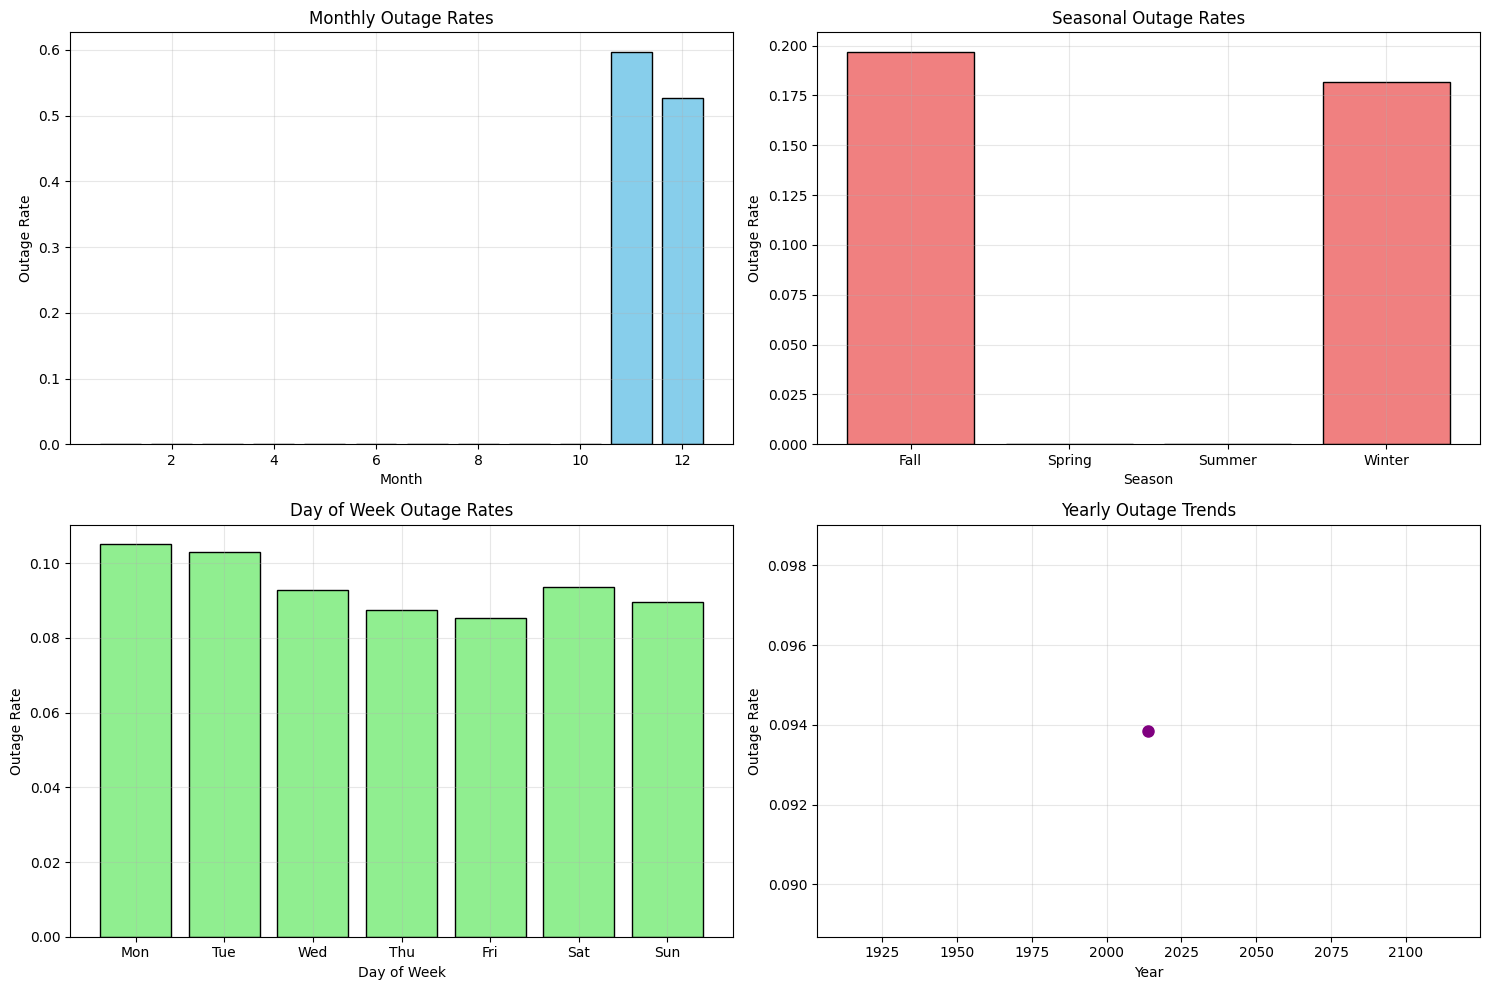

In [4]:
# Monthly and seasonal outage rates
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly outage rates
monthly_rates = df.groupby('month')['outage_occurred'].mean()
axes[0,0].bar(monthly_rates.index, monthly_rates.values, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Outage Rate')
axes[0,0].set_title('Monthly Outage Rates')
axes[0,0].grid(True, alpha=0.3)

# Seasonal outage rates
seasonal_rates = df.groupby('season')['outage_occurred'].mean()
axes[0,1].bar(seasonal_rates.index, seasonal_rates.values, color='lightcoral', edgecolor='black')
axes[0,1].set_xlabel('Season')
axes[0,1].set_ylabel('Outage Rate')
axes[0,1].set_title('Seasonal Outage Rates')
axes[0,1].grid(True, alpha=0.3)

# Day of week patterns
dow_rates = df.groupby('day_of_week')['outage_occurred'].mean()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,0].bar(range(7), dow_rates.values, color='lightgreen', edgecolor='black')
axes[1,0].set_xlabel('Day of Week')
axes[1,0].set_ylabel('Outage Rate')
axes[1,0].set_title('Day of Week Outage Rates')
axes[1,0].set_xticks(range(7))
axes[1,0].set_xticklabels(dow_names)
axes[1,0].grid(True, alpha=0.3)

# Yearly trends
yearly_rates = df.groupby('year')['outage_occurred'].mean()
axes[1,1].plot(yearly_rates.index, yearly_rates.values, marker='o', linewidth=2, markersize=8, color='purple')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Outage Rate')
axes[1,1].set_title('Yearly Outage Trends')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

## Weather-Outage Correlations

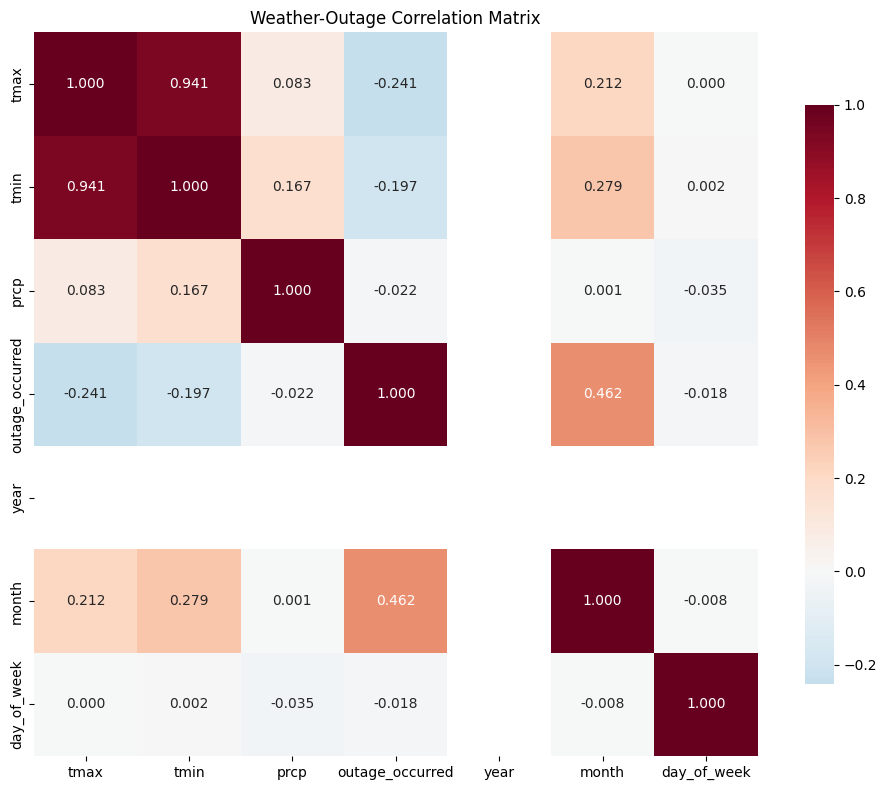

In [5]:
# Correlation heatmap
numeric_cols = ['tmax', 'tmin', 'prcp', 'outage_occurred', 'year', 'month', 'day_of_week']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Weather-Outage Correlation Matrix')
plt.tight_layout()
plt.savefig(output_dir / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

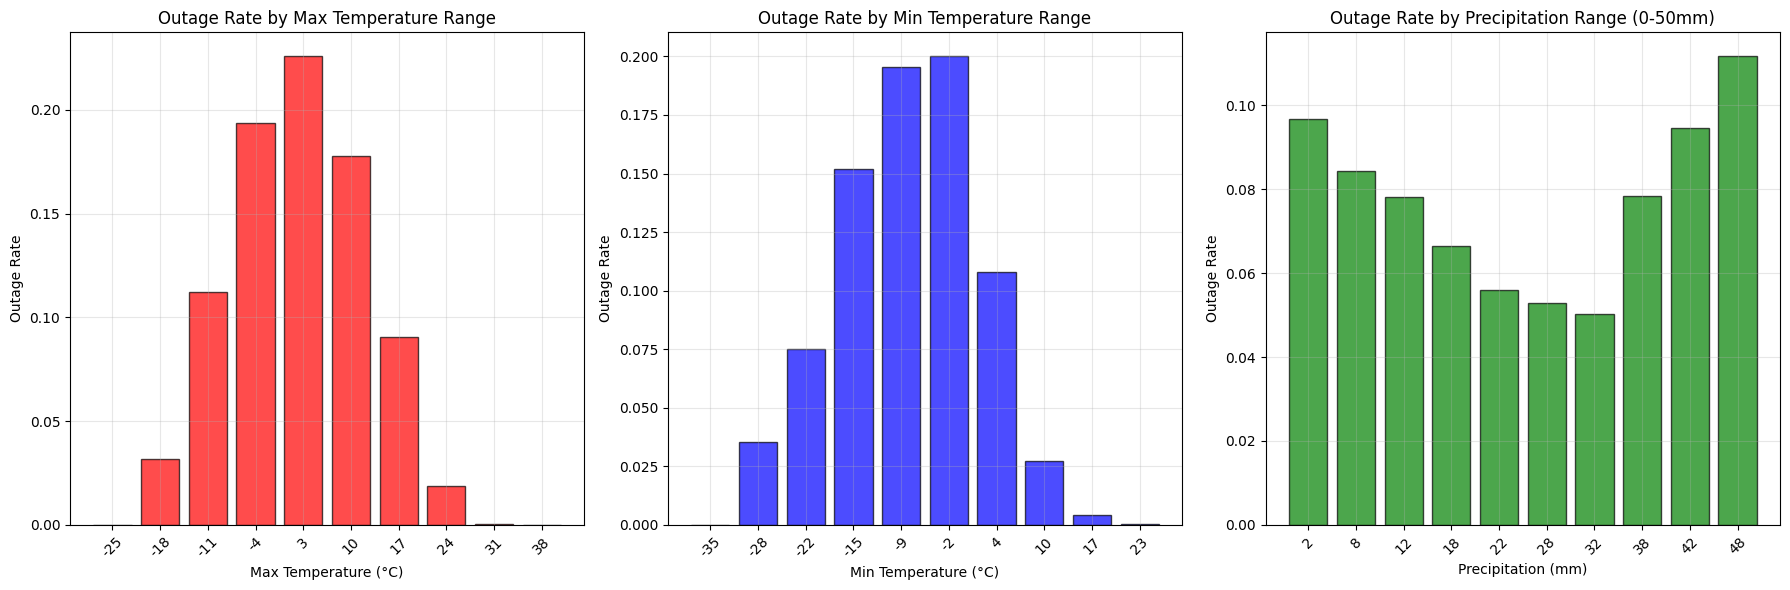

Weather Threshold Insights:
Max temp range with highest outage rate: (-0.2, 6.8] (0.226)
Min temp range with highest outage rate: (-5.6, 0.8] (0.200)
Precipitation range with highest outage rate: (45.0, 50.0] (0.112)


In [6]:
# Weather threshold analysis - outage rates by weather bins
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Temperature max bins
tmax_bins = pd.cut(df['tmax'], bins=10, precision=1)
tmax_rates = df.groupby(tmax_bins)['outage_occurred'].agg(['count', 'mean'])
tmax_rates = tmax_rates[tmax_rates['count'] >= 100]  # Only bins with sufficient data

bin_centers = [interval.mid for interval in tmax_rates.index]
axes[0].bar(range(len(bin_centers)), tmax_rates['mean'], color='red', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Max Temperature (°C)')
axes[0].set_ylabel('Outage Rate')
axes[0].set_title('Outage Rate by Max Temperature Range')
axes[0].set_xticks(range(len(bin_centers)))
axes[0].set_xticklabels([f'{x:.0f}' for x in bin_centers], rotation=45)
axes[0].grid(True, alpha=0.3)

# Temperature min bins
tmin_bins = pd.cut(df['tmin'], bins=10, precision=1)
tmin_rates = df.groupby(tmin_bins)['outage_occurred'].agg(['count', 'mean'])
tmin_rates = tmin_rates[tmin_rates['count'] >= 100]

bin_centers = [interval.mid for interval in tmin_rates.index]
axes[1].bar(range(len(bin_centers)), tmin_rates['mean'], color='blue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Min Temperature (°C)')
axes[1].set_ylabel('Outage Rate')
axes[1].set_title('Outage Rate by Min Temperature Range')
axes[1].set_xticks(range(len(bin_centers)))
axes[1].set_xticklabels([f'{x:.0f}' for x in bin_centers], rotation=45)
axes[1].grid(True, alpha=0.3)

# Precipitation bins (focus on 0-50mm range where most data is)
prcp_filtered = df[df['prcp'] <= 50]  # Focus on normal precipitation range
prcp_bins = pd.cut(prcp_filtered['prcp'], bins=10, precision=1)
prcp_rates = prcp_filtered.groupby(prcp_bins)['outage_occurred'].agg(['count', 'mean'])
prcp_rates = prcp_rates[prcp_rates['count'] >= 100]

bin_centers = [interval.mid for interval in prcp_rates.index]
axes[2].bar(range(len(bin_centers)), prcp_rates['mean'], color='green', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Precipitation (mm)')
axes[2].set_ylabel('Outage Rate')
axes[2].set_title('Outage Rate by Precipitation Range (0-50mm)')
axes[2].set_xticks(range(len(bin_centers)))
axes[2].set_xticklabels([f'{x:.0f}' for x in bin_centers], rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'weather_threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Weather Threshold Insights:")
max_tmax_idx = tmax_rates['mean'].idxmax()
max_tmin_idx = tmin_rates['mean'].idxmax()
max_prcp_idx = prcp_rates['mean'].idxmax()

print(f"Max temp range with highest outage rate: {max_tmax_idx} ({tmax_rates.loc[max_tmax_idx, 'mean']:.3f})")
print(f"Min temp range with highest outage rate: {max_tmin_idx} ({tmin_rates.loc[max_tmin_idx, 'mean']:.3f})")
print(f"Precipitation range with highest outage rate: {max_prcp_idx} ({prcp_rates.loc[max_prcp_idx, 'mean']:.3f})")

## Extreme Weather Analysis

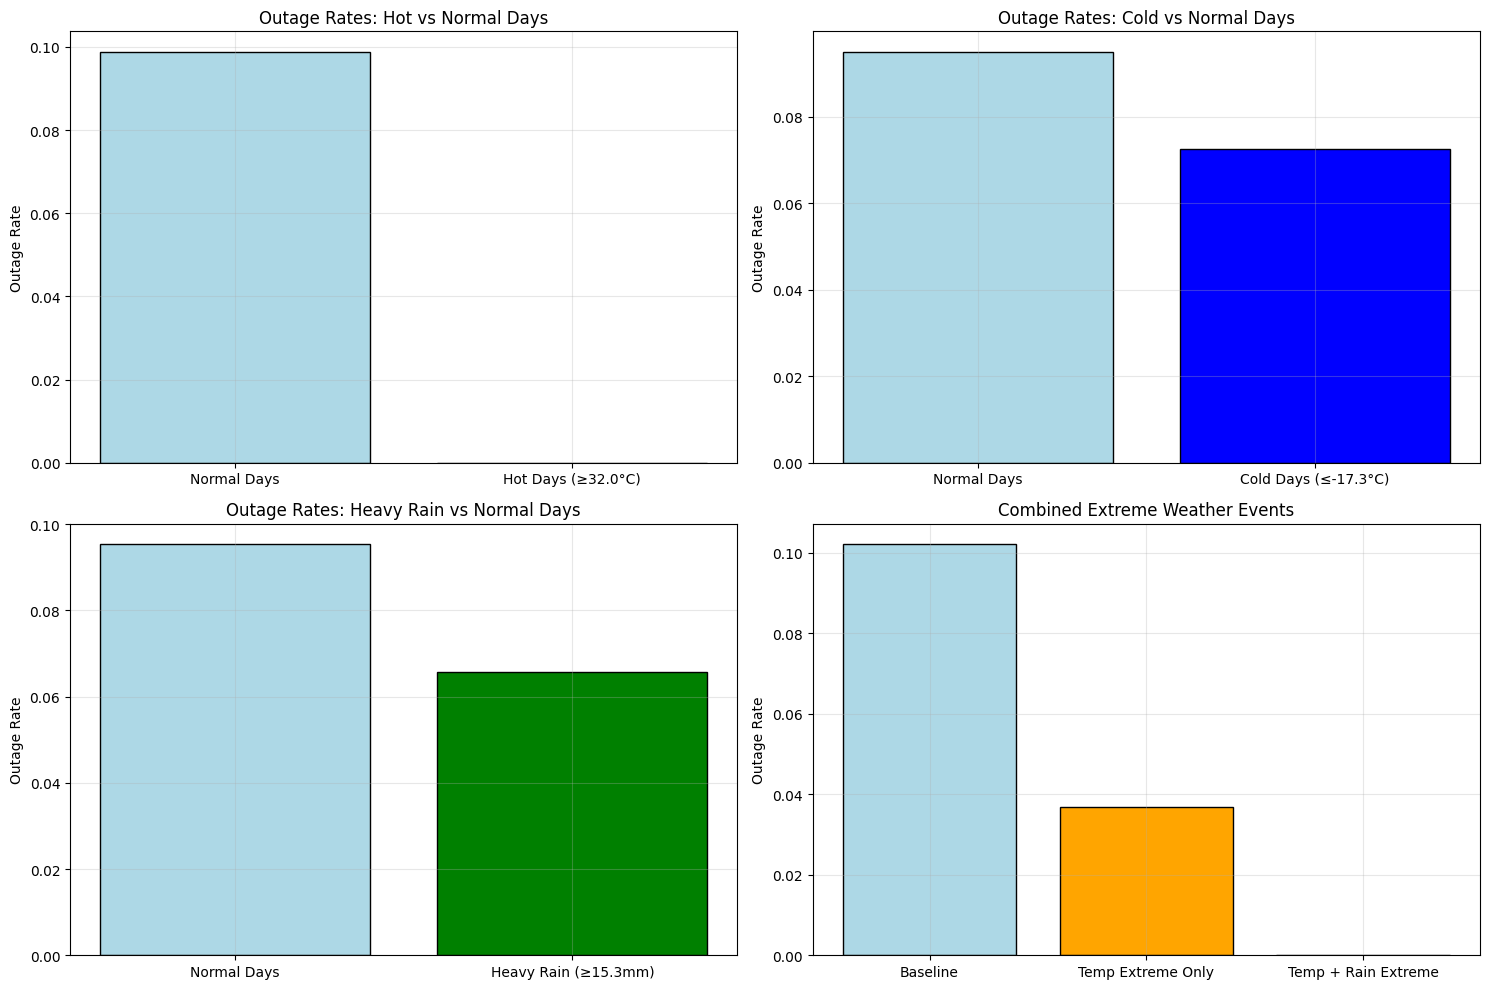

In [7]:
# Extreme weather events and outage rates
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Temperature extremes
tmax_95 = df['tmax'].quantile(0.95)
tmin_5 = df['tmin'].quantile(0.05)
prcp_95 = df['prcp'].quantile(0.95)

# Hot days
hot_days = df['tmax'] >= tmax_95
hot_outage_rate = df[hot_days]['outage_occurred'].mean()
normal_outage_rate = df[~hot_days]['outage_occurred'].mean()

axes[0,0].bar(['Normal Days', f'Hot Days (≥{tmax_95:.1f}°C)'], 
              [normal_outage_rate, hot_outage_rate], 
              color=['lightblue', 'red'], edgecolor='black')
axes[0,0].set_ylabel('Outage Rate')
axes[0,0].set_title('Outage Rates: Hot vs Normal Days')
axes[0,0].grid(True, alpha=0.3)

# Cold days
cold_days = df['tmin'] <= tmin_5
cold_outage_rate = df[cold_days]['outage_occurred'].mean()
normal_cold_rate = df[~cold_days]['outage_occurred'].mean()

axes[0,1].bar(['Normal Days', f'Cold Days (≤{tmin_5:.1f}°C)'], 
              [normal_cold_rate, cold_outage_rate], 
              color=['lightblue', 'blue'], edgecolor='black')
axes[0,1].set_ylabel('Outage Rate')
axes[0,1].set_title('Outage Rates: Cold vs Normal Days')
axes[0,1].grid(True, alpha=0.3)

# Heavy precipitation
heavy_prcp = df['prcp'] >= prcp_95
heavy_outage_rate = df[heavy_prcp]['outage_occurred'].mean()
normal_prcp_rate = df[~heavy_prcp]['outage_occurred'].mean()

axes[1,0].bar(['Normal Days', f'Heavy Rain (≥{prcp_95:.1f}mm)'], 
              [normal_prcp_rate, heavy_outage_rate], 
              color=['lightblue', 'green'], edgecolor='black')
axes[1,0].set_ylabel('Outage Rate')
axes[1,0].set_title('Outage Rates: Heavy Rain vs Normal Days')
axes[1,0].grid(True, alpha=0.3)

# Combined extreme events
extreme_temp = (df['tmax'] >= tmax_95) | (df['tmin'] <= tmin_5)
extreme_combo = extreme_temp & heavy_prcp
combo_rate = df[extreme_combo]['outage_occurred'].mean() if extreme_combo.sum() > 0 else 0
temp_only_rate = df[extreme_temp & ~heavy_prcp]['outage_occurred'].mean()
baseline_rate = df[~extreme_temp & ~heavy_prcp]['outage_occurred'].mean()

axes[1,1].bar(['Baseline', 'Temp Extreme Only', 'Temp + Rain Extreme'], 
              [baseline_rate, temp_only_rate, combo_rate], 
              color=['lightblue', 'orange', 'darkred'], edgecolor='black')
axes[1,1].set_ylabel('Outage Rate')
axes[1,1].set_title('Combined Extreme Weather Events')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'extreme_weather_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Geographic Analysis

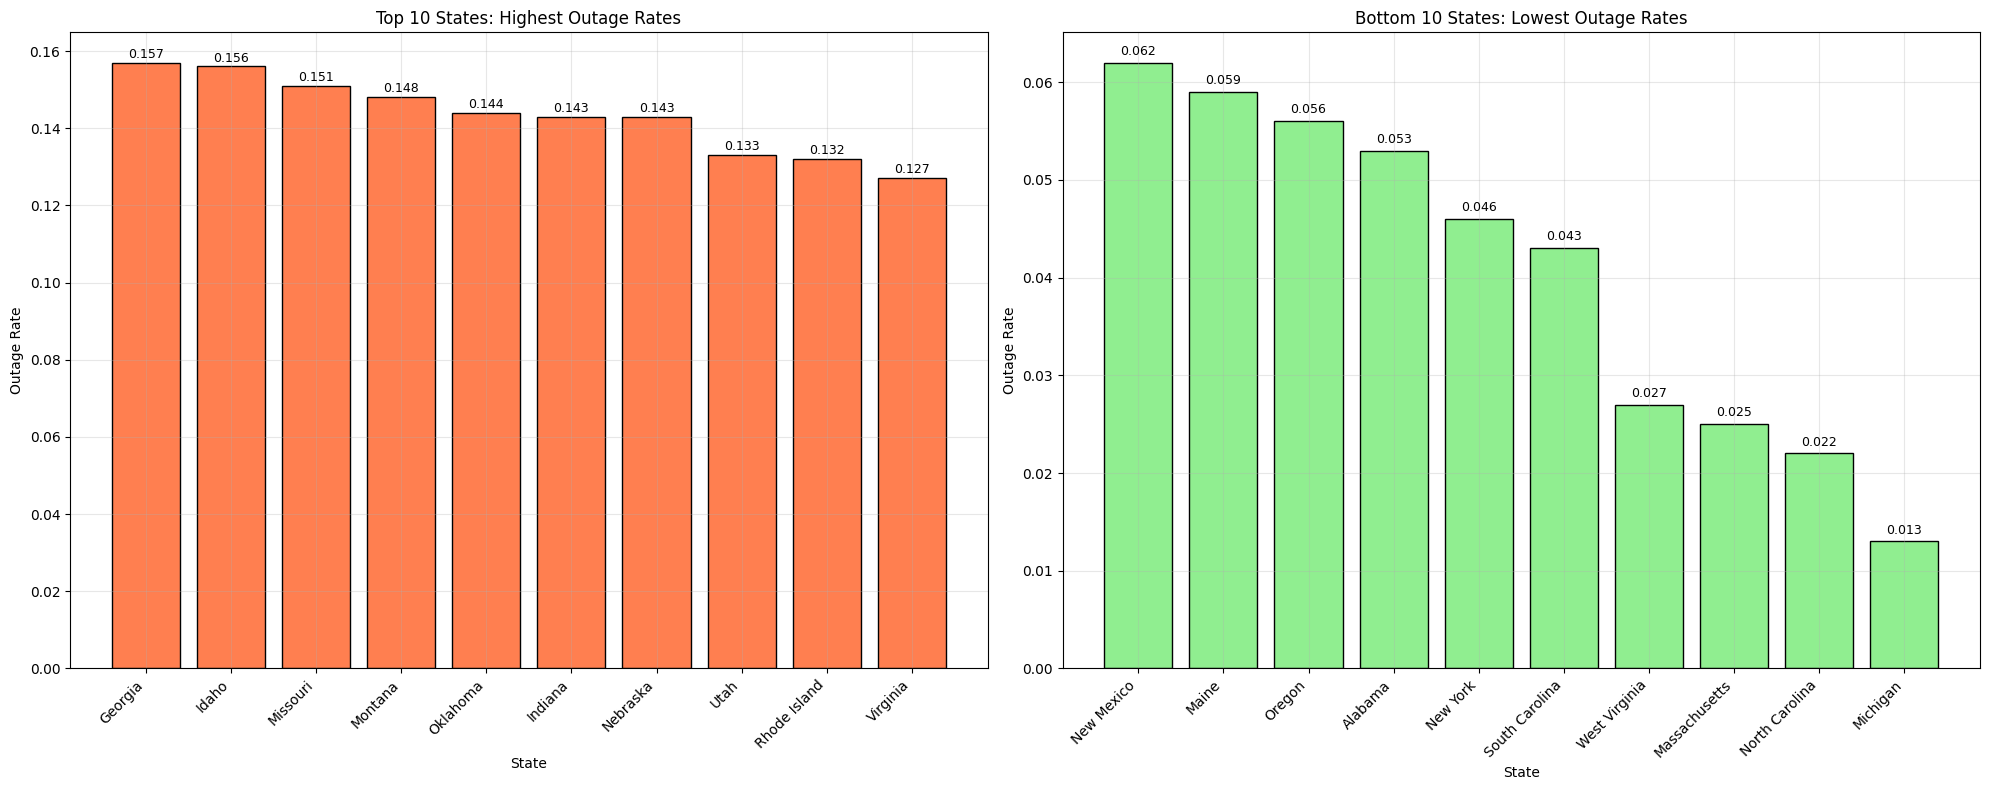

Top 10 States by Outage Rate (Highest):
              observations  outage_rate
state                                  
Georgia               2920        0.157
Idaho                 1095        0.156
Missouri              5475        0.151
Montana               5475        0.148
Oklahoma              6570        0.144
Indiana              23360        0.143
Nebraska              5110        0.143
Utah                 10585        0.133
Rhode Island          1095        0.132
Virginia              1825        0.127

Bottom 10 States by Outage Rate (Lowest):
                observations  outage_rate
state                                    
New Mexico              5475        0.062
Maine                   5840        0.059
Oregon                  3650        0.056
Alabama                 8030        0.053
New York                1825        0.046
South Carolina          2555        0.043
West Virginia           2190        0.027
Massachusetts           4015        0.025
North Carolina   

In [8]:
# State-level outage rates
state_stats = df.groupby('state').agg({
    'outage_occurred': ['count', 'mean']
}).round(3)
state_stats.columns = ['observations', 'outage_rate']
state_stats = state_stats[state_stats['observations'] >= 1000]  # Min sample size
state_stats = state_stats.sort_values('outage_rate', ascending=False)

# Get top and bottom states
top_10_states = state_stats.head(10)
bottom_10_states = state_stats.tail(10)

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Top 10 states (highest outage rates)
bars1 = ax1.bar(range(len(top_10_states)), top_10_states['outage_rate'], 
                color='coral', edgecolor='black')
ax1.set_xlabel('State')
ax1.set_ylabel('Outage Rate')
ax1.set_title('Top 10 States: Highest Outage Rates')
ax1.set_xticks(range(len(top_10_states)))
ax1.set_xticklabels(top_10_states.index, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Bottom 10 states (lowest outage rates)
bars2 = ax2.bar(range(len(bottom_10_states)), bottom_10_states['outage_rate'], 
                color='lightgreen', edgecolor='black')
ax2.set_xlabel('State')
ax2.set_ylabel('Outage Rate')
ax2.set_title('Bottom 10 States: Lowest Outage Rates')
ax2.set_xticks(range(len(bottom_10_states)))
ax2.set_xticklabels(bottom_10_states.index, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(output_dir / 'state_outage_rates_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Top 10 States by Outage Rate (Highest):")
print(top_10_states)
print("\nBottom 10 States by Outage Rate (Lowest):")
print(bottom_10_states)

# Calculate insights
highest_rate = top_10_states['outage_rate'].iloc[0]
lowest_rate = bottom_10_states['outage_rate'].iloc[-1]
rate_ratio = highest_rate / lowest_rate

print(f"\nKey Insights:")
print(f"Highest outage rate: {top_10_states.index[0]} ({highest_rate:.3f})")
print(f"Lowest outage rate: {bottom_10_states.index[-1]} ({lowest_rate:.3f})")
print(f"Risk ratio (highest/lowest): {rate_ratio:.1f}x")

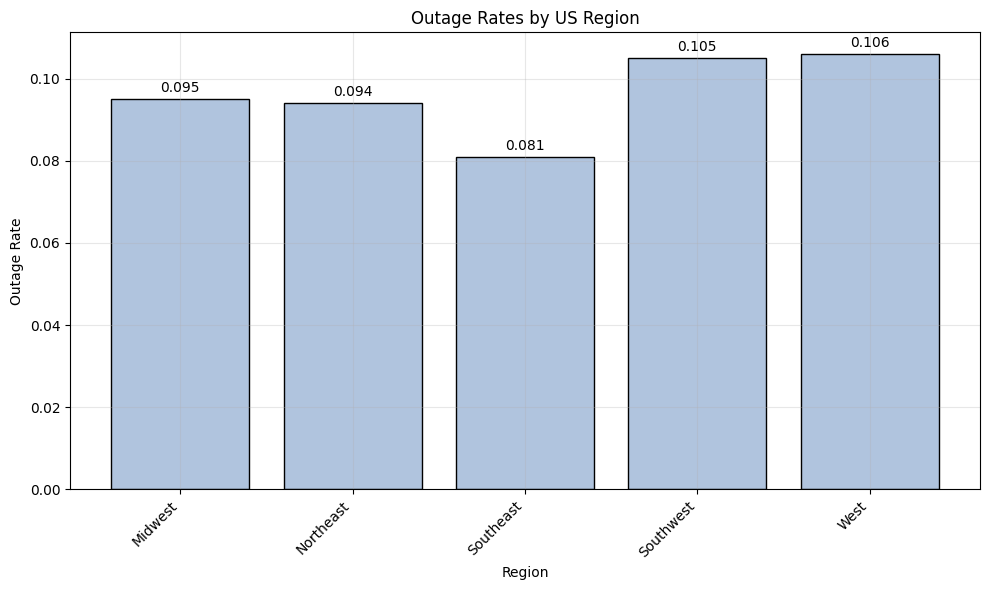

Regional Outage Statistics:
           observations  outage_rate
region                              
Midwest          144175        0.095
Northeast         43800        0.094
Southeast         95265        0.081
Southwest         14235        0.105
West              68985        0.106


In [9]:
# Regional analysis
if 'region' in df.columns:
    regional_stats = df.groupby('region').agg({
        'outage_occurred': ['count', 'mean']
    }).round(3)
    regional_stats.columns = ['observations', 'outage_rate']
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(regional_stats.index, regional_stats['outage_rate'], 
                   color='lightsteelblue', edgecolor='black')
    plt.xlabel('Region')
    plt.ylabel('Outage Rate')
    plt.title('Outage Rates by US Region')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'regional_outage_rates.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Regional Outage Statistics:")
    print(regional_stats)
else:
    print("Regional data not available - create regions in EDA notebook first")

## Summary Statistics

In [10]:
# Key visualization insights summary
print("VISUALIZATION INSIGHTS SUMMARY")
print("=" * 50)

# Basic statistics
print(f"Dataset size: {len(df):,} observations")
print(f"Overall outage rate: {df['outage_occurred'].mean():.3f}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")

# Weather extremes impact
tmax_95 = df['tmax'].quantile(0.95)
tmin_5 = df['tmin'].quantile(0.05)  
prcp_95 = df['prcp'].quantile(0.95)

hot_rate = df[df['tmax'] >= tmax_95]['outage_occurred'].mean()
cold_rate = df[df['tmin'] <= tmin_5]['outage_occurred'].mean()
heavy_rain_rate = df[df['prcp'] >= prcp_95]['outage_occurred'].mean()
baseline_rate = df['outage_occurred'].mean()

print(f"\nWeather Impact on Outage Rates:")
print(f"Baseline rate: {baseline_rate:.3f}")
print(f"Hot days (≥{tmax_95:.1f}°C): {hot_rate:.3f} ({hot_rate/baseline_rate:.1f}x baseline)")
print(f"Cold days (≤{tmin_5:.1f}°C): {cold_rate:.3f} ({cold_rate/baseline_rate:.1f}x baseline)")
print(f"Heavy rain (≥{prcp_95:.1f}mm): {heavy_rain_rate:.3f} ({heavy_rain_rate/baseline_rate:.1f}x baseline)")

# Seasonal patterns
seasonal_rates = df.groupby('season')['outage_occurred'].mean()
print(f"\nSeasonal Outage Rates:")
for season, rate in seasonal_rates.items():
    print(f"{season}: {rate:.3f}")

# Geographic insights
if len(df['state'].unique()) > 1:
    state_rates = df.groupby('state')['outage_occurred'].mean()
    print(f"\nGeographic Variation:")
    print(f"Highest risk state: {state_rates.idxmax()} ({state_rates.max():.3f})")
    print(f"Lowest risk state: {state_rates.idxmin()} ({state_rates.min():.3f})")
    print(f"Geographic risk ratio: {state_rates.max()/state_rates.min():.1f}x")

print(f"\nVisualizations saved to: {output_dir}")
print("Analysis complete!")

VISUALIZATION INSIGHTS SUMMARY
Dataset size: 366,460 observations
Overall outage rate: 0.094
Date range: 2014-01-01 to 2014-12-31

Weather Impact on Outage Rates:
Baseline rate: 0.094
Hot days (≥32.0°C): 0.000 (0.0x baseline)
Cold days (≤-17.3°C): 0.072 (0.8x baseline)
Heavy rain (≥15.3mm): 0.066 (0.7x baseline)

Seasonal Outage Rates:
Fall: 0.197
Spring: 0.000
Summer: 0.000
Winter: 0.182

Geographic Variation:
Highest risk state: Illinois (0.164)
Lowest risk state: Michigan (0.013)
Geographic risk ratio: 12.2x

Visualizations saved to: ../../notebooks/outputs/milestone_1/visualizations
Analysis complete!
